# References

## General
* https://medium.com/data-deft/data-science-pipeline-in-python-255150adb98f

## Specific

### Feature Selection
* FeatureTools: https://docs.featuretools.com

### Time Series
* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

### Graph Analysis
* Graph analysis: https://towardsdatascience.com/getting-started-with-graph-analysis-in-python-with-pandas-and-networkx-5e2d2f82f18e


In [18]:
!ls -la /data/induction/titanic

total 32
drwxr-xr-x 4 root root   128 Jan  7  2018 .
drwxr-xr-x 3 root root    96 Jan  7  2018 ..
-rw-r--r-- 1 root root  8932 Jan  7  2018 test.csv.bz2
-rw-r--r-- 1 root root 17152 Jan  7  2018 train.csv.bz2


# Import Libraries

In [19]:
# import basic libraries
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

# import plot libraries
import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline

# import ml libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC

# list number of files
import os
print(os.listdir('/data/induction/titanic'))

['test.csv.bz2', 'train.csv.bz2']


# Read Data

In [72]:
# read data
from subprocess import check_output
print(check_output(["ls", "."]).decode("utf8"))
train = pd.read_csv("/data/induction/titanic/train.csv.bz2")
test = pd.read_csv("/data/induction/titanic/test.csv.bz2")

error-function-for-linear-regression.ipynb
pandas-tutorial.ipynb
python-data-science-01.ipynb
recursion-examples.ipynb
scala-data-science-01.ipynb
titanic-project.ipynb



# Check shape

In [23]:
# check shape
print("Train rows and columns : ", train.shape)
print("Test rows and columns : ", test.shape)

Train rows and columns :  (891, 12)
Test rows and columns :  (418, 11)


# Check Column Types

In [73]:
# check column types
ctype = train.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Display Data Header

In [28]:
# display data header
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Numerical Data Distribution

In [29]:
# numerical data distribution
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Categorical Data Distribution

In [30]:
# categorical data distribution
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Allum, Mr. Owen George",male,347082,B96 B98,S
freq,1,577,7,4,644


# Check Missing Values

In [31]:
# check missing values
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df


,column_name,missing_count
11,Embarked,2
5,Age,177
10,Cabin,687


# Impute/Treat Missing Values

In [40]:
# impute/treat missing values
train['Sex'] = train['Sex'].fillna(train['Sex'].value_counts().index[0]) # for categorical
train['Age'].fillna(train['Age'].mean(), inplace=True) # for numerical (mean or median)

# Check outliers

In [44]:
# check ouliers
fmean = train['Fare'].mean()
fstd = train['Fare'].std()
train.ix[np.abs(train['Fare']-fmean) > (3*fstd), 'Fare'] # upper outliers
train.ix[np.abs(train['Fare']-fmean) < -(3*fstd), 'Fare'] # lower outliers

Series([], Name: Fare, dtype: float64)

# Treat Outliers

In [46]:
# treat outliers
train.ix[np.abs(train['Fare']-fmean) > (3*fstd), 'Fare'] = fmean + (3*fstd) # treat upper outliers
train.ix[np.abs(train['Fare']-fmean) < -(3*fstd), 'Fare'] = -(fmean + (3*fstd)) # treat lower outliers

# Univariate Analysis

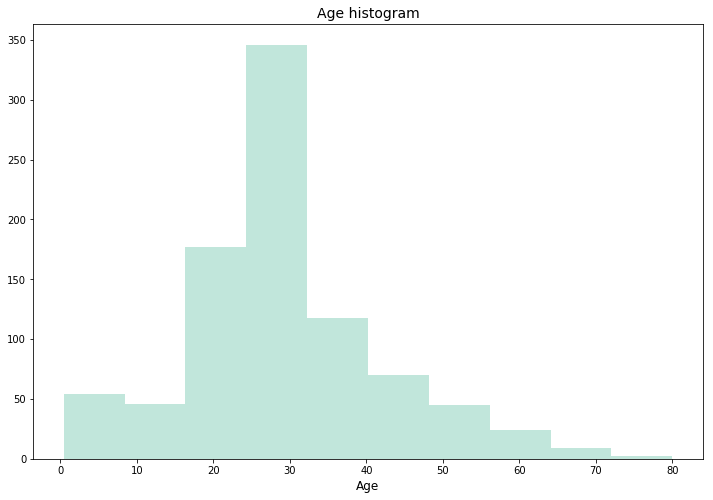

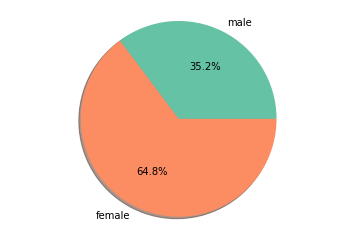

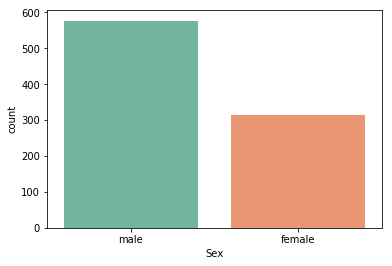

In [53]:
# univariate analysis
# histogram of numerical column
plt.figure(figsize=(12,8))
sns.distplot(train["Age"].values, bins=10, kde=False)
plt.xlabel('Age', fontsize=12)
plt.title("Age histogram", fontsize=14)
plt.show()
# charts of categorical column
labels = train['Sex'].unique()
sizes = [train['Sex'].value_counts()[1],
 train['Sex'].value_counts()[0]
 ]
# pie plot for categorical column
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
# bar plot for categorical column
fig2, ax2 = plt.subplots()
sns.countplot("Sex", data=train)
plt.show()


# Bivariate Analysis

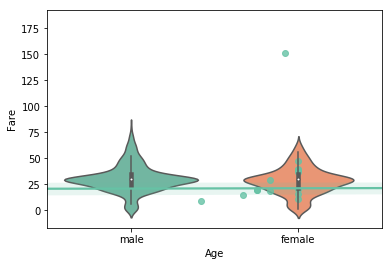

In [56]:
# bivariate analysis
#sns.barplot(x='Sex', y='Embarked', data=train) # categorical vs categorical
sns.violinplot(x='Sex', y='Age', data=train) # categorical vs numerical
sns.regplot(x="Age", y="Fare", data=train) # numerical vs numerical

# Multivariate Analysis

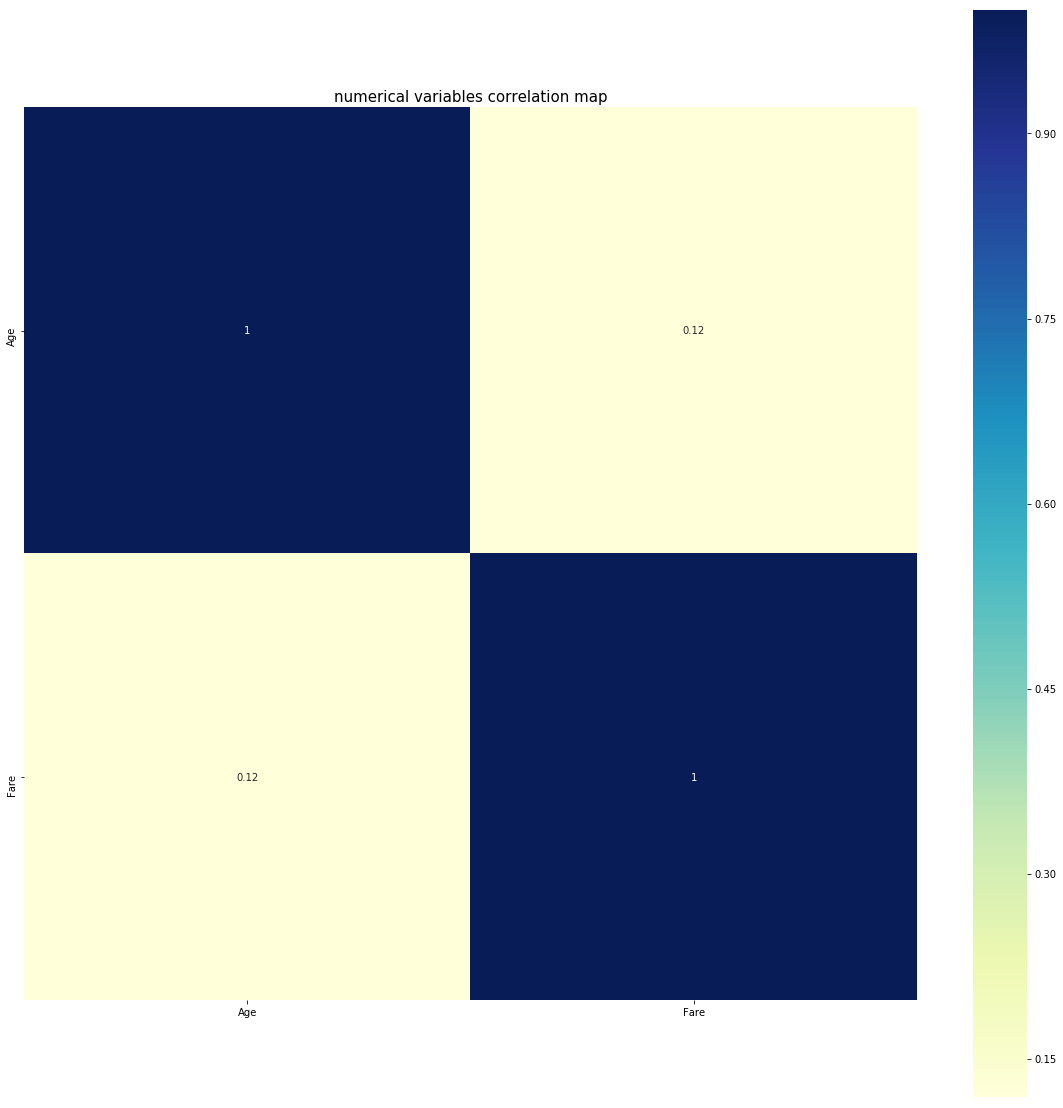

In [63]:
# multivariate analysis
temp = train[['Sex', 'Age', 'Fare', 'Embarked']]
corrmat = temp.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("numerical variables correlation map", fontsize=15)
plt.show()


# Split Data

In [79]:
# split data
y = train['Sex']
X = train.drop('Sex', axis=1, inplace=False)
#X = train
X_train, X_val, y_train, y_val = train_test_split(X, y,random_state = 123)

# Feature Engineering on train/valid

In [80]:
# feature engineering on train/valid
label = LabelEncoder()
X_train['Sex'] = label.fit_transform(X_train['Sex']) # for categorical data
scaler = MinMaxScaler() # for numerical data
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

KeyError: 'Sex'

# Build Model on train

In [81]:
# build model on train
model = linear_model.LogisticRegression(C=1e5) # RandomForestClassifier(), SVC(), RandomForestRegressor() etc
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
model.score(X_train, y_train)

ValueError: could not convert string to float: 'Q'

# Evaluate on valid

In [82]:
# evaluate on valid
confusion_matrix(y_val, y_pred) # for categorical target
mean_squared_error(y_true, y_pred) # for numerical target

NameError: name 'y_pred' is not defined

# K-fold Cross-Validation

In [83]:
# k-fold cross-validation
model = svm.SVC(kernel=’linear’, C=1)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(“Score: %0.2f (+/- %0.2f)” % (scores.mean(), scores.std() * 2))

SyntaxError: invalid character in identifier (<ipython-input-83-a96f9cc7c675>, line 2)

# Hyper-parameter Tuning

In [84]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
 for C in [0.001, 0.01, 0.1, 1, 10, 100]:
 # for each combination of parameters,
 # train an SVC
 svm = SVC(gamma=gamma, C=C)
 # perform cross-validation
 scores = cross_val_score(svm, X_train, y_train, cv=5)
 # compute mean cross-validation accuracy
 score = np.mean(scores)
 # if we got a better score, store the score and parameters
 if score > best_score:
 best_score = score
 best_parameters = {‘C’: C, ‘gamma’: gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_train, y_train)

IndentationError: expected an indented block (<ipython-input-84-2c9a500aa5c3>, line 5)